In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

###Q1

The function we want to learn

In [0]:
# suitable for one or multiple examples
def target_f(arg_vec):
  return 1 + arg_vec + arg_vec**2 + arg_vec**3
DOMAIN = np.arange(start=-5.0,stop=5.0,step=0.01)
IMAGE = target_f(DOMAIN)

####seif a

In [0]:
# setup
P = 500
x = np.random.uniform(low=-5.0,high=5.0,size=P)

# defining a 'data matrix':
# each column is an example: first coordinate is 1 as we want to learn a weight for the intercept
# the second coordinate is a RV x which distributed uniformally between -5 and 5
# in our case: the matrix is 2X500
per_input = np.row_stack((np.repeat(1,P), x))

# compute the image of the examples
y = target_f(x)

In [0]:
# A function for learning weights according to inverse correlation matrix method
# x: 2XP examples matrix
# y: P-dim true labels vector
# returns the value of w
def corr_inv_method(x,y):
  C = (x @ x.T)/x.shape[1]
  C_inv = np.linalg.inv(C)
  u = (y.T @ x.T)/x.shape[1]
  w = C_inv @ u
  return w

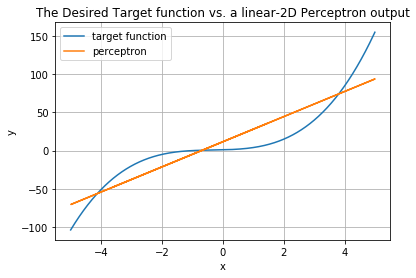

In [0]:
w = corr_inv_method(x=per_input,y=y)
y_hat = per_input.T @ w

plt.plot(DOMAIN,IMAGE, label="target function")
plt.plot(x,y_hat, label="perceptron")
plt.legend()
plt.title("The Desired Target function vs. a linear-2D Perceptron output")
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.show()

###### sanity check: comparison to sklearn

In [0]:
# reg = LinearRegression().fit(per_input.T, y)
# reg.intercept_
# reg.coef_

In [0]:
# comparison = pd.DataFrame({"sklearn":reg.predict(per_input.T), "course": y_hat})
# stam
# (np.around(stam["sklearn"],3) == np.around(stam["course"],3)).all()

####seif b

In [0]:
# P: number of examples
# y: A vector represents the true labels of the examples
# y_hat: a vector represents the learned labels
def compute_train_error(P,y,y_hat):
  train_error = (1/(2*P))*np.sum((y_hat-y)**2)
  return train_error

# w: the learned weights which we want to examine above the true target function
def compute_general_error(w):
  y_general = np.row_stack((np.repeat(1,DOMAIN.shape[0]),DOMAIN)).T @ w
  general_error = (1/(2*DOMAIN.shape[0]))*np.sum((IMAGE-y_general)**2)
  return general_error

print("training error is:\n", compute_train_error(P=P,y=y,y_hat=y_hat))
print("generalization error is:\n",compute_general_error(w=w))

training error is:
 205.52236530752347
generalization error is:
 209.23731089781856


The values are pretty close to each other. However the generalization error is larger as naturally options for general examples are infinitives, but the training examples number is restricted. Since the perceptron learn its weights according to its training examples, he performs better on them.

###Q2

In [0]:
# A function to generate training and generalization error for a given number of input examples
NUM_OF_ITERATIONS = 100
def simmulation(p):
  train_errors = np.zeros(NUM_OF_ITERATIONS)
  general_errors = np.zeros(NUM_OF_ITERATIONS)
  for i in range(NUM_OF_ITERATIONS):
    x = np.random.uniform(low=-5.0,high=5.0,size=p)
    per_input = np.row_stack((np.repeat(1,p), x))
    y = target_f(x)
    w = corr_inv_method(x=per_input, y=y)
    y_hat = per_input.T @ w
    train_errors[i] = compute_train_error(P=p,y=y,y_hat=y_hat)
    general_errors[i] = compute_general_error(w=w)
  return np.mean(train_errors), np.mean(general_errors)

Apply the experiment as described

In [0]:
P = pd.Series(np.arange(5,101,step=5), name="P")
results = pd.DataFrame.from_records(P.apply(lambda p: simmulation(p)), columns=["training","generalizaion"])
experiment = pd.concat([P, results], axis=1)

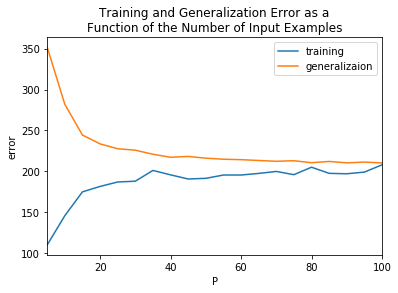

In [0]:
experiment.plot(x="P")
plt.title("Training and Generalization Error as a\nFunction of the Number of Input Examples")
plt.ylabel("error")
plt.show()

The training error increases with the increasing of P, because the combination of the examples is getting complicated and it's more difficult the set the weights accordingly. In contrast, the generalization error is decreasing with P, since larger set of examples represents more accurately infinitive set of general examples, makeing the corresponding learned weights producing less generalization error.

###Q3

Implementation of gradient learning methods

In [0]:
# A function for updating weights vector according to batch gradient algorithm
# w: current weight vector
# eta: learning rate
# x: 2XP examples matrix
# y: P-dim true labels vector
# returns the updated value of w
def L2D_batch_gradient_update(w,eta,x,y):
  grad_1 = x[0,:]*(x.T@w - y) # vector of delta w1 (the i entry in the vec is the i val of the summation)
  grad_2 = x[1,:]*(x.T@w - y)
  gradient = np.mean(np.array([grad_1,grad_2]), axis=1) # mean is like sum over p and divide by p
  return w - eta*gradient

# A function for updating weights vector according to online gradient algorithm
# w: current weight vector
# eta: learning rate
# x: 2-dim vector representing a random example from overall examples
# y: scalar representing the true label of example x
# returns the updated value of w
def L2D_online_gradient_update(w,eta,x,y):
  gradient = (x.T@w - y)*x
  return w - eta*gradient

Experiment setup

In [0]:
P = 100
ETA = 0.01
x = np.random.uniform(low=-5.0,high=5.0,size=P)
per_input = np.row_stack((np.repeat(1,P),x))
y = target_f(x)

seif a: batch gradient learning algoritm

In [0]:
batch_train_errors = np.zeros(P)
batch_general_errors = np.zeros(P)
w = np.array([1,1])

for i in range(100):
  w = L2D_batch_gradient_update(w=w,eta=ETA,x=per_input,y=y)
  y_hat = per_input.T@w
  batch_train_errors[i] = compute_train_error(P=P, y=y, y_hat=y_hat)
  batch_general_errors[i] = compute_general_error(w=w)

seif b: online gradient learning algoritm

In [0]:
online_train_errors = np.zeros(P)
online_general_errors = np.zeros(P)
w = np.array([1,1])

# shuffle the examples as required
examples = np.random.choice(per_input.shape[1],size=P,replace=False)
for i, col in enumerate(examples):
  x = per_input[:,col]
  label = y[col]
  w = L2D_online_gradient_update(w=w,eta=ETA,x=x,y=label)
  y_hat = per_input.T@w
  online_train_errors[i] = compute_train_error(P=P, y=y, y_hat=y_hat)
  online_general_errors[i] = compute_general_error(w=w)

seif c: correlation inverse method

In [0]:
w = corr_inv_method(x=per_input,y=y)
y_hat = per_input.T@w
corr_train_error = compute_train_error(P=P, y=y, y_hat=y_hat)
corr_general_error = compute_general_error(w=w)

The experiment Results

In [0]:
results = pd.DataFrame({"batch train":batch_train_errors,\
                        "batch generalization":batch_general_errors,\
                        "online train":online_train_errors,\
                        "online generalization":online_general_errors,\
                        "correlation inverse train":np.repeat(corr_train_error,P),\
                        "correlation inverse generalization":np.repeat(corr_general_error,P)},\
                       index=np.arange(100))
results

,batch train,batch generalization,online train,online generalization,correlation inverse train,correlation inverse generalization
0,987.484528,1029.108666,1082.546984,1126.981616,202.404611,207.076043
1,867.258488,905.554757,785.941398,823.329985,202.404611,207.076043
2,765.825538,801.233125,472.314704,501.652698,202.404611,207.076043
3,680.240263,713.135021,461.956513,490.873459,202.404611,207.076043
4,608.019035,638.722974,465.944602,495.047039,202.404611,207.076043
...,...,...,...,...,...,...
95,205.506197,214.513090,210.975937,222.056756,202.404611,207.076043
96,205.444466,214.407761,208.546385,219.063137,202.404611,207.076043
97,205.383965,214.304118,208.758670,219.409751,202.404611,207.076043
98,205.324669,214.202129,208.925216,219.667933,202.404611,207.076043


####Q4

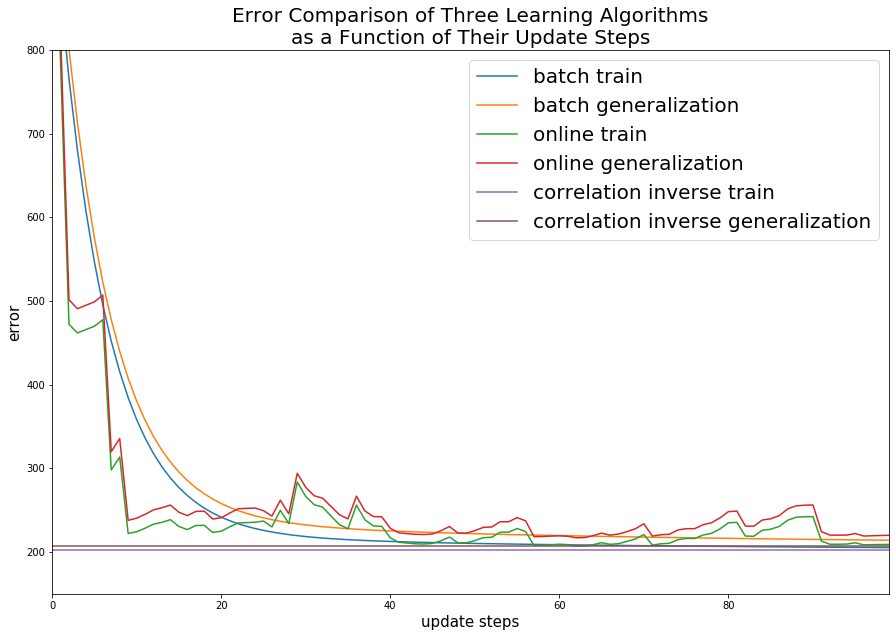

In [0]:
results.plot(figsize=(15,10))
plt.legend(fontsize=20)
plt.title("Error Comparison of Three Learning Algorithms\nas a Function of Their Update Steps", fontsize=20)
plt.xlabel("update steps", fontsize=15)
plt.ylabel("error", fontsize=15)
plt.ylim(150,800)
plt.show()

The correlation method is clearly stable as it's not an iterative algorithm. Moreover, it achieves the best results, since we choose the weights to be the ones which minimize the squared error in advance, and found them analytically. The same thing isn't true when it comes to the batch gradient algorithm: this algo initialized with an arbitrary weights (causes a large error in the first few iterations), and changes them consecutively. The update reduces the error, as it's done with respect to the error function's gradient direction (the opposite one). Since we're dealing with a convex function(and we've picked a relatively small ETA), each update bring us closer to the global minimum point where the squared error the least. This core prinicple we've mentioned about the batch gradient is also true when it comes to the online gradient, execpt that difference: instead of minimizing the whole training error function it's minimizing only the error on a random example. As we see, this diiference results in more variability of the error function compared to the batch (variance of mean is typically lesser). We can also be impressed that sometimes this kind of update cause an increasement of the error, as we are not guaranteed that every single example will be enough similar to the previous ones. Therfore, optimizing the weights concerning to former examples not always results in decreasement of a latter example.